In [1]:
import warnings
warnings.filterwarnings("ignore")

import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from src.data_funcs import BikeData
%matplotlib inline
plt.style.use('fivethirtyeight')

In [2]:
data = BikeData('bike_data.pickle')

In [3]:
trips_per_month = data.rentals_per_day()[:-1].resample('MS').mean()

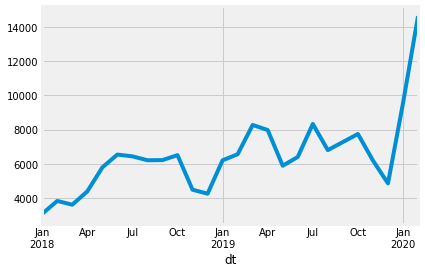

In [4]:
trips_per_month.plot()

In [6]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [8]:
warnings.filterwarnings("ignore")
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(trips_per_month,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:515.2328580229008
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:248.33499724099514
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:259.945644574231
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:41.363549453185804
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:469.5491020241519
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:223.08305721763128
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:255.17121055695094
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:42.49239018841391
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:429.9935744007224
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:220.08029130701556
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:239.2494554029385
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:nan
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:409.66317799144963
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:202.6396553875851
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:239.62456231009713
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:1.0968293698242517
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:447.6802125648405
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:239.24960940852404
ARIMA(1, 0, 0)x(

In [9]:
#OUR LOWEST AIC SCORE IS ACHIEVED WITH
#ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:236.5687267136548

In [32]:
model = sm.tsa.statespace.SARIMAX(trips_per_month,
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = model.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4919      0.201      2.453      0.014       0.099       0.885
sigma2      3.748e+06   2.41e+06      1.557      0.119   -9.69e+05    8.47e+06


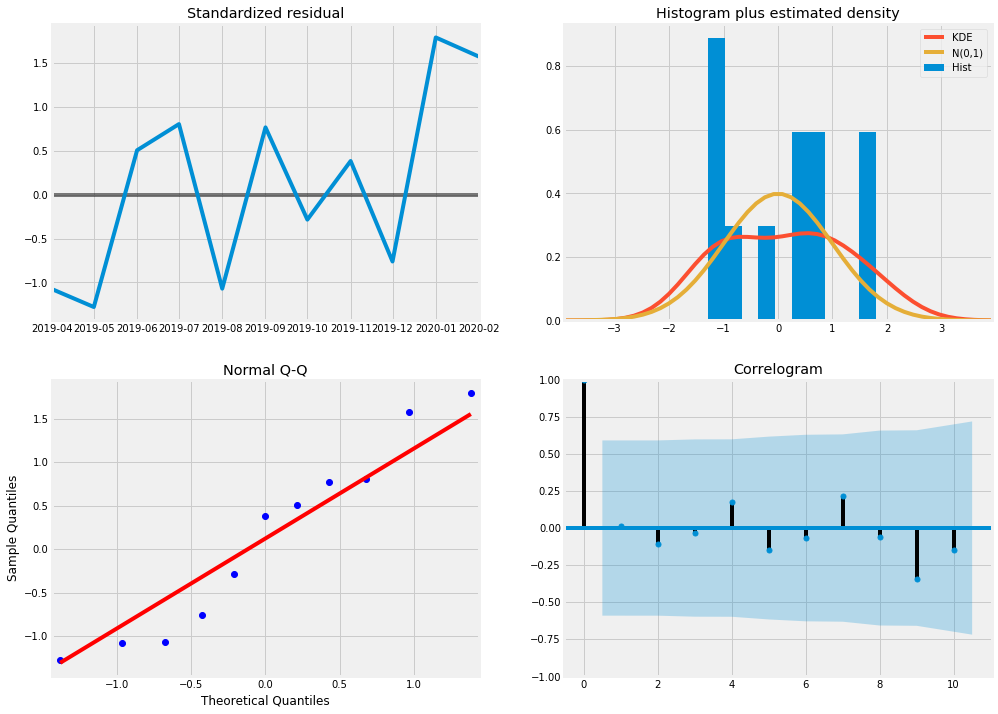

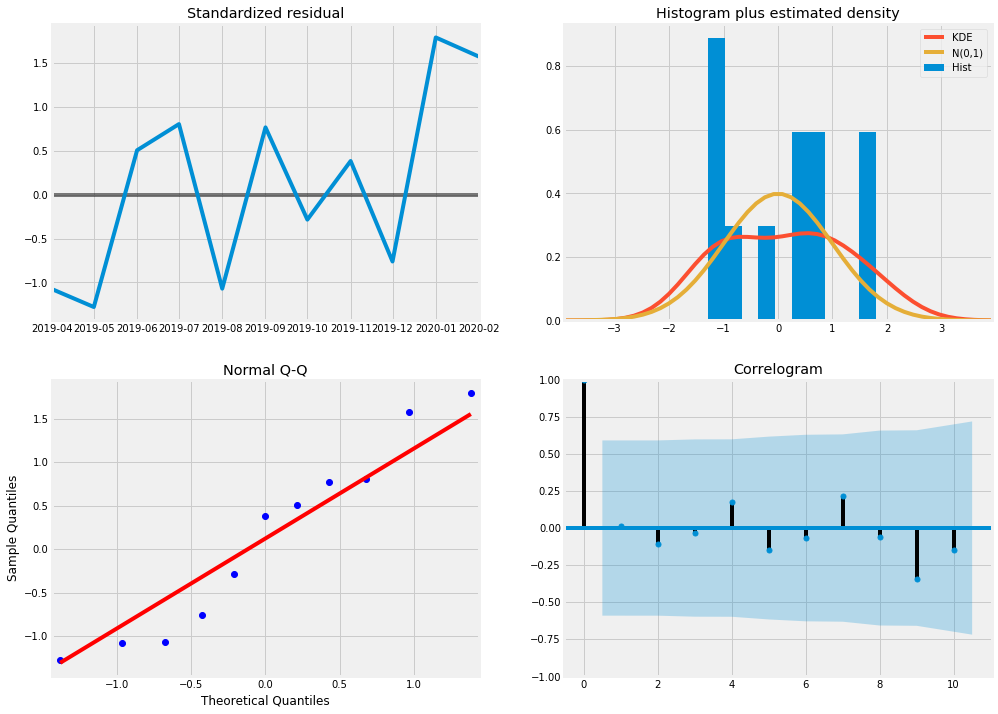

In [33]:
results.plot_diagnostics(figsize=(15, 12))

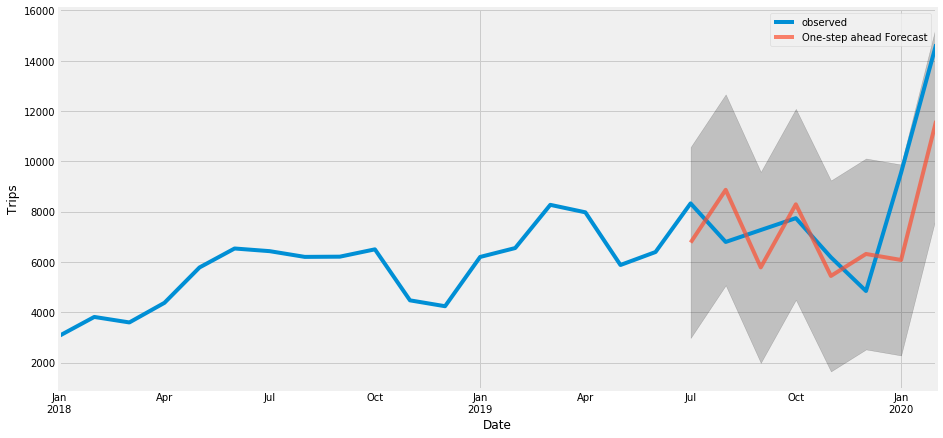

In [34]:
pred = results.get_prediction(start=pd.to_datetime('2019-07-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = trips_per_month.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Trips')
plt.legend()
plt.show()